In [1]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT= 4
VALIDATION_COUNT_PCT = 0.1
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 500
AUGMENT_BRIGHTNESS = False

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import horovod.tensorflow.keras as hvd
import gc; gc.enable() # memory is tight
import tensorflow as tf

In [3]:
hvd.init()

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')

In [5]:
ship_dir = '/mnt/fsx/airbus_data/'
train_image_dir = os.path.join(ship_dir, 'train_small')

In [6]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [7]:
train_masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_train.csv'))
print(train_masks.shape[0], 'masks found')
print(train_masks['ImageId'].value_counts().shape[0])
print(train_masks.head())

1218 masks found
816
                                             ImageId  \
0  000155de5_cc7a0ba3-e660-472b-b8f2-ec2fe1174400...   
1  00021ddc3_8e5aa526-f180-48f5-aad9-f0ca73bcf015...   
2  00021ddc3_8e5aa526-f180-48f5-aad9-f0ca73bcf015...   
3  00021ddc3_8e5aa526-f180-48f5-aad9-f0ca73bcf015...   
4  00021ddc3_8e5aa526-f180-48f5-aad9-f0ca73bcf015...   

                                       EncodedPixels  
0  186376 1 187141 4 187907 7 188672 10 189438 13...  
1    48177 1 48943 5 49710 4 50476 6 51245 3 52014 1  
2            51279 1 52047 2 52815 2 53583 3 54352 3  
3  650 11 1419 9 2186 11 2953 12 3722 10 4489 10 ...  
4  665 11 1432 11 2200 10 2968 9 3735 11 4504 10 ...  


In [8]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [9]:
train_gen = make_image_gen(train_masks)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


In [10]:
valid_masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_valid.csv'))
validation_samples = valid_masks.shape[0]
print(valid_masks.shape[0], 'masks found')

325 masks found
141
                                             ImageId  \
0  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   
1  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   
2  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   
3  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   
4  0002756f7_cce98450-44fe-488b-9f05-bd0d0748abf4...   

                                       EncodedPixels  
0  309689 4 310455 6 311222 8 311989 9 312755 11 ...  
1  357323 1 358089 3 358855 6 359620 9 360388 10 ...  
2  190702 1 191469 6 192237 6 193005 7 193772 7 1...  
3  451292 1 452058 4 452824 6 453590 9 454358 9 4...  
4  222632 3 223398 5 224165 7 224932 8 225699 10 ...  


In [11]:
valid_gen = make_image_gen(valid_masks, validation_samples) # pull all validation samples
valid_x, valid_y = next(valid_gen)
print('x', valid_x.shape, valid_x.min(), valid_x.max())
print('y', valid_y.shape, valid_y.min(), valid_y.max())

x (325, 768, 768, 3) 0.0 1.0
y (325, 768, 768, 1) 0 1


In [12]:
# Contruct a model using UNET with RESTNET 34
import tensorflow as tf
import segmentation_models as sm
import tensorflow.keras.backend as K
sm.set_framework('tf.keras')
K.set_image_data_format('channels_last')
model = sm.Unet('resnet34', classes=1, input_shape=(768,768,3), encoder_weights='imagenet')
model.summary()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 768, 768, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 774, 774, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 384, 384, 64) 9408        zero_padding2d[0][0]             
______________________________________________

In [13]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.dtypes.cast(y_true_f, tf.float32) * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(tf.dtypes.cast(y_true_f, tf.float32)) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [14]:
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = 1e-4
scaled_lr = lr * hvd.size()
weight_path="{}/weights/{}_weights.best.hdf5".format(ship_dir,'seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

# reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
#                                    patience=3,
#                                    verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
hvdBroadcast = hvd.callbacks.BroadcastGlobalVariablesCallback(0)

hvdMetricsAvg = hvd.callbacks.MetricAverageCallback()

# Horovod: using `lr = 1.0 * hvd.size()` from the very beginning leads to worse final
# accuracy. Scale the learning rate `lr = 1.0` ---> `lr = 1.0 * hvd.size()` during
# the first three epochs. See https://arxiv.org/abs/1706.02677 for details.
hvdLRWarmup = hvd.callbacks.LearningRateWarmupCallback(warmup_epochs=3, initial_lr=scaled_lr, verbose=1)
    

In [16]:
callbacks_list = [early,hvdBroadcast, hvdMetricsAvg, hvdLRWarmup]
# Horovod: save checkpoints only on worker 0 to prevent other workers from corrupting them.
if hvd.rank() == 0:
    callbacks_list.append(checkpoint)

In [17]:
from tensorflow.keras.optimizers import Adam
opt = Adam(scaled_lr, decay=1e-6)
opt = hvd.DistributedOptimizer(opt)
model.compile(optimizer=opt, loss=bce_logdice_loss, metrics=[dice_coef, 'binary_accuracy', true_positive_rate], experimental_run_tf_function=False)

In [18]:
import sys
oldStdout = sys.stdout
file = open('{}/logs/airbus_unet34_keras_{}.out'.format(ship_dir, hvd.local_rank()), 'w')
sys.stdout = file

In [21]:
step_count = min(MAX_TRAIN_STEPS, (train_masks.shape[0]//BATCH_SIZE) // hvd.size())
loss_history = [model.fit(train_gen, 
#                           batch_size=BATCH_SIZE,
                          epochs=NB_EPOCHS,
                          steps_per_epoch=step_count,
                          validation_data=(valid_x, valid_y),
                          callbacks=callbacks_list,
                          verbose=1 if hvd.rank() == 0 else 0)]

Epoch 1/20
325/304 [================================] - 9s 27ms/sample - loss: 4.7794 - dice_coef: 0.0108 - binary_accuracy: 0.9940 - true_positive_rate: 0.0000e+00

Epoch 00001: val_dice_coef improved from -inf to 0.01085, saving model to /mnt/fsx/airbus_data//weights/seg_model_weights.best.hdf5
304/304 [==============================] - 94s 309ms/step - loss: 4.3615 - dice_coef: 0.0275 - binary_accuracy: 0.9128 - true_positive_rate: 0.9554 - val_loss: 4.8038 - val_dice_coef: 0.0108 - val_binary_accuracy: 0.9940 - val_true_positive_rate: 0.0000e+00
Epoch 2/20
325/304 [================================] - 6s 19ms/sample - loss: 4.4416 - dice_coef: 0.0156 - binary_accuracy: 0.9942 - true_positive_rate: 0.0319

Epoch 00002: val_dice_coef improved from 0.01085 to 0.01563, saving model to /mnt/fsx/airbus_data//weights/seg_model_weights.best.hdf5
304/304 [==============================] - 74s 243ms/step - loss: 2.7369 - dice_coef: 0.0881 - binary_accuracy: 0.9951 - true_positive_rate: 0.9541

KeyboardInterrupt: 

In [ ]:
sys.stdout = oldStdout

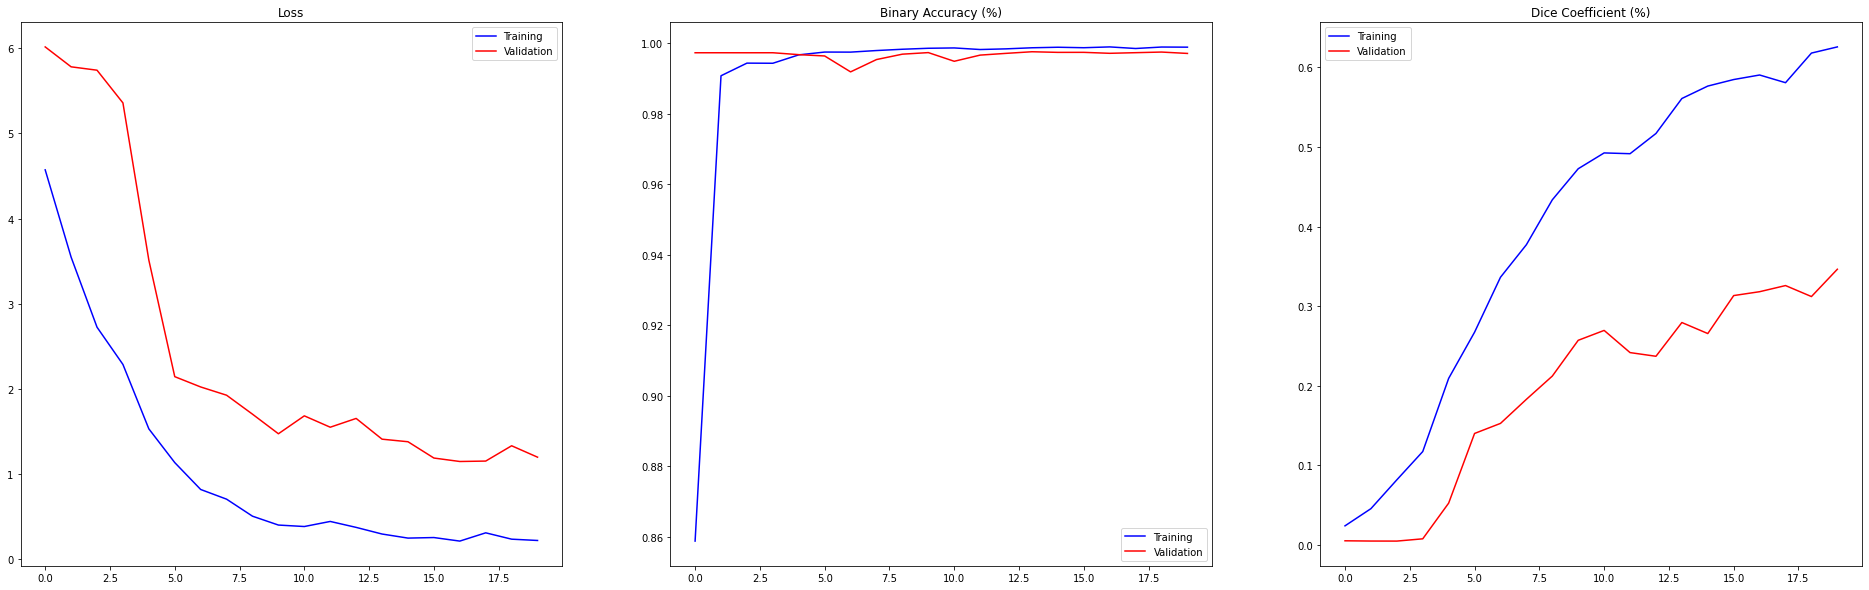

In [39]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(33, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')
    
    _ = ax3.plot(epochs, np.concatenate([mh.history['dice_coef'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_dice_coef'] for mh in loss_history]), 'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Dice Coefficient (%)')


show_loss(loss_history)


In [32]:
model.load_weights(weight_path)
model.save('{}/weights/best_seg_model_2.h5'.format(ship_dir))

In [33]:
import os
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [34]:
from matplotlib.cm import get_cmap
from skimage.morphology import binary_opening, disk, label

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

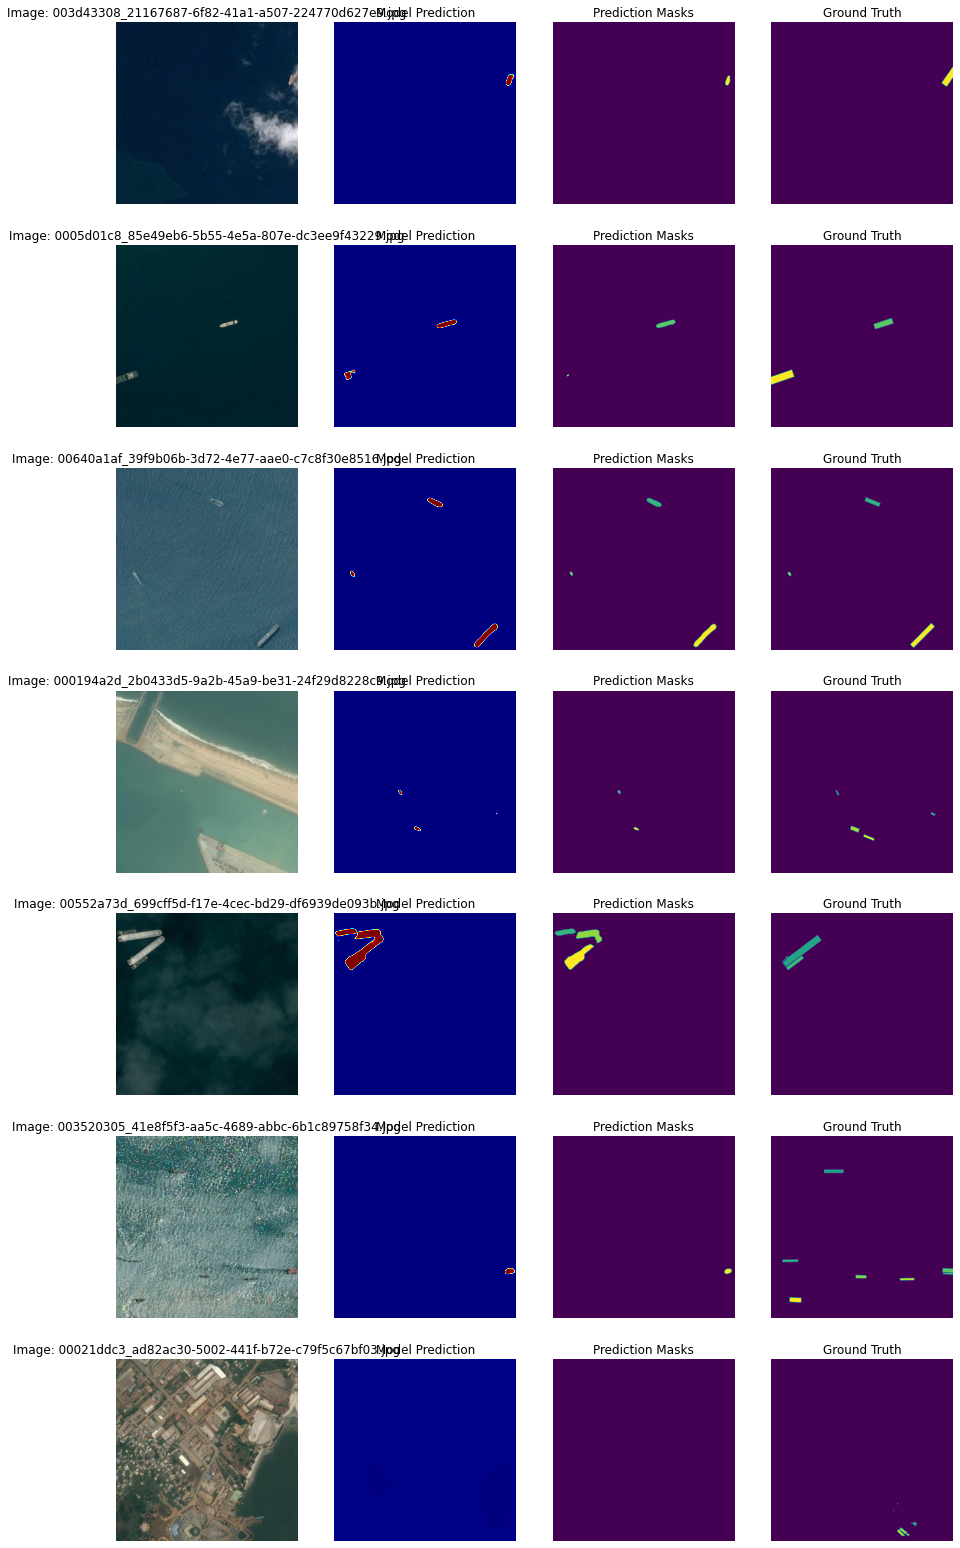

In [35]:
## Get a sample of each group of ship count
samples = balanced_valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    smoothened_img = smooth(first_seg)
    reencoded = masks_as_color(multi_rle_encode(smoothened_img))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

In [36]:
import os
test_image_files = os.listdir(test_image_dir)

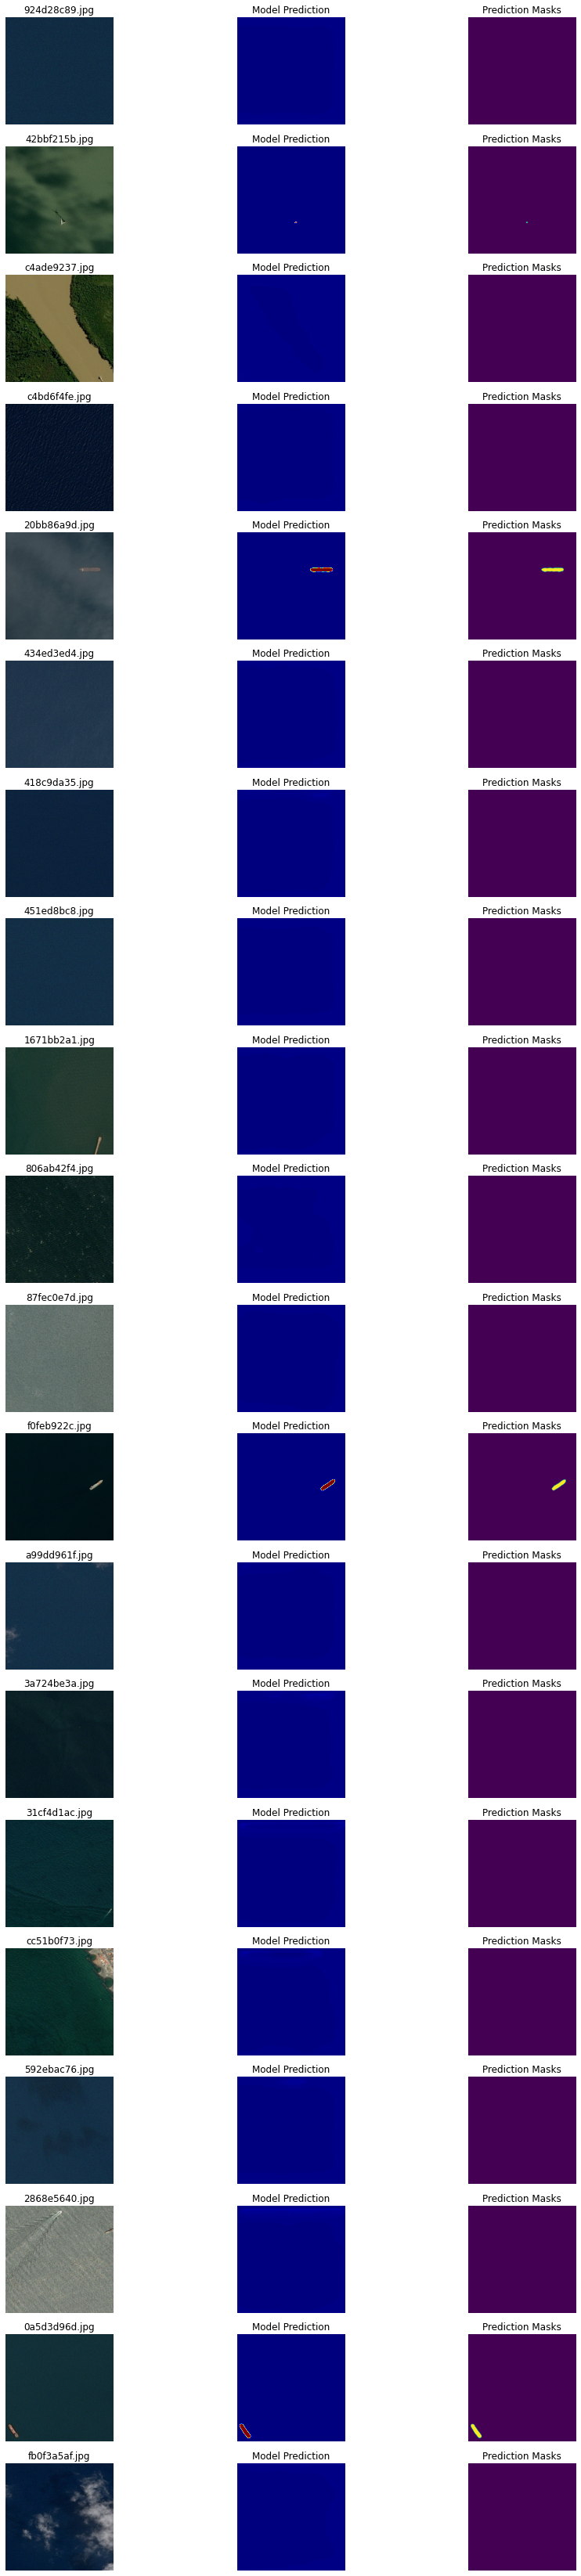

In [37]:
test_images_count = 20
fig, m_axs = plt.subplots(len(test_image_files[:test_images_count]), 3, figsize = (15, test_images_count*3))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3), c_img_name in zip(m_axs, test_image_files[:test_images_count]):
    first_seg, first_img = raw_prediction(c_img_name, test_image_dir)
    ax1.imshow(first_img)
    ax1.set_title(c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    smoothened_img = smooth(first_seg)
    reencoded = masks_as_color(multi_rle_encode(smoothened_img))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')